In [1]:
import tensorflow as tf
import os 
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input
import time
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras.models import load_model

# Preparing data

In [2]:
data_path = 'data'
image_extensions = ['.jpeg', '.jpg', '.bmp', '.png']

In [8]:
# Clearing the data (Only if not sure)
for image_folder in os.listdir(data_path):
    for image in os.listdir(os.path.join(data_path,image_folder)):
        image_path = os.path.join(data_path, image_folder, image)
        try:
            img = Image.open(image_path)
            img.verify()
            if img is None:
                raise Exception("Failed to load image")
            file, ext = os.path.splitext(image_path)
            if ext not in image_extensions:
                print('Image has a wrong extension {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Image has a wrong extension data\horses\2HF6HN5-jpg.webp
Image has a wrong extension data\horses\horse-breeds.jpg.webp
Image has a wrong extension data\horses\p3715-kon-na-kiju-hobby-horses-brauny-knorr-toys-40103.webp


In [5]:
# Loading the data
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=8)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 240 files belonging to 2 classes.


In [6]:
batch = data_iterator.next()

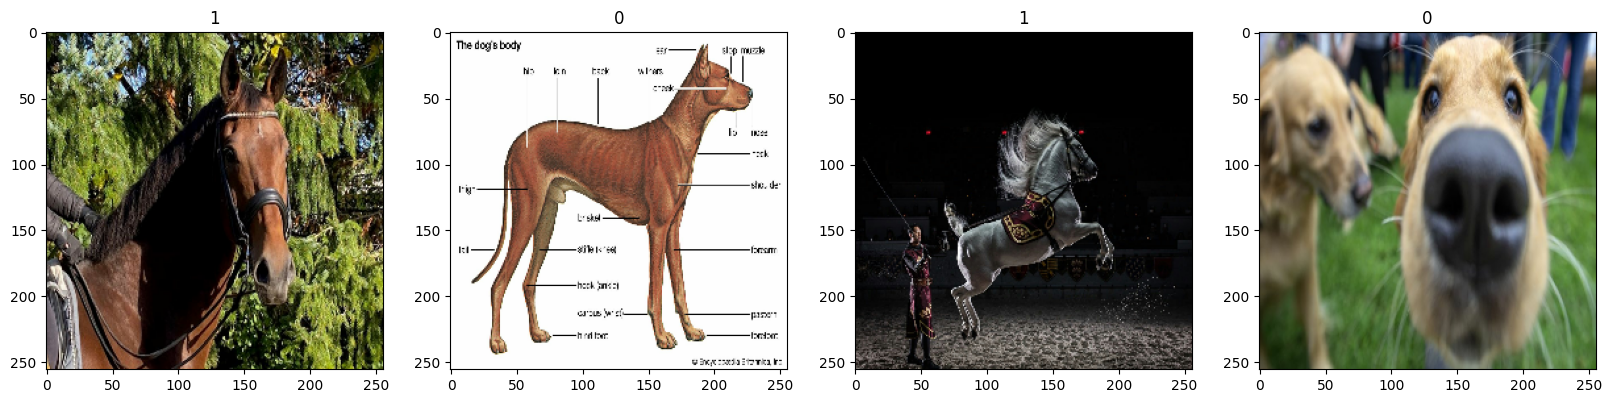

In [24]:
# Plotting data 0-Dogs 1-Horses
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [7]:
# Scaling pixel values to fit between 0 and 1
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()

# Creating data subsets

In [25]:
len(data)

30

In [9]:
# Dividing data to subsets
print(f'Train: {30 * 0.7}') #21
print(f'Val: {30 * 0.2}')   #6
print(f'Test: {30 * 0.1}')  #3

Train: 21.0
Val: 6.0
Test: 3.0


In [10]:
# Creating train, validation and test batches
train = data.take(21)
val = data.skip(21).take(6)
test = data.skip(21+6).take(3)

# Building and training the model

In [11]:
# Creating the model
model = Sequential()
model.add(Input(shape=(256,256,3)))
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile('adam',loss=tf._losses.BinaryCrossentropy(), metrics=['accuracy'])

In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,692,001 (14.08 MB)

 Trainable params: 3,692,001 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Training the model
log_directory = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory)
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3947 - loss: 1.5583 - val_accuracy: 0.5208 - val_loss: 0.6857
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5542 - loss: 0.6816 - val_accuracy: 0.5833 - val_loss: 0.6689
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6431 - loss: 0.6267 - val_accuracy: 0.7292 - val_loss: 0.5511
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8070 - loss: 0.4899 - val_accuracy: 0.5417 - val_loss: 0.7201
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8320 - loss: 0.3725 - val_accuracy: 0.6667 - val_loss: 0.5578
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8109 - loss: 0.3574 - val_accuracy: 0.8542 - val_loss: 0.3220
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9480 - loss: 0.2140 - val_accuracy: 0.8750 - val_loss: 0.2765
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9617 - loss: 0.1612 - val_accuracy: 0.9167 - v

# Evaluating the model

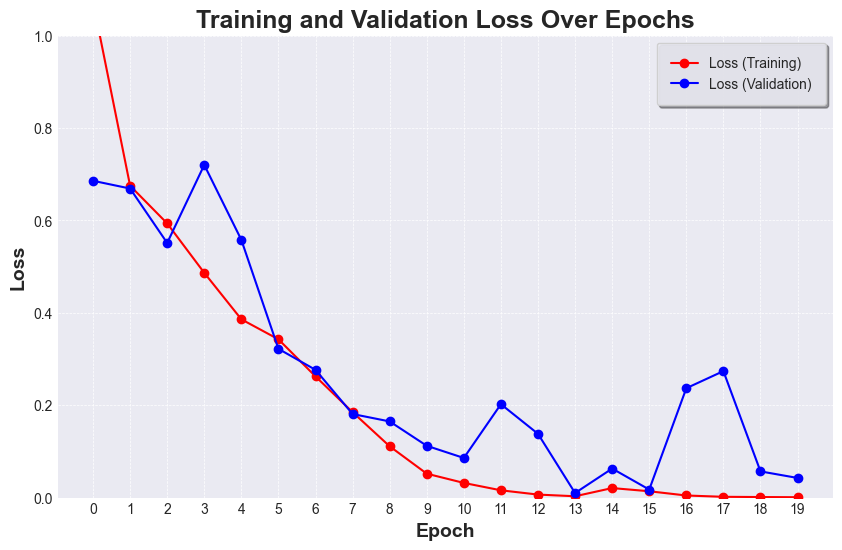

In [19]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(history.history['loss'], color='red', marker='o', label='Loss (Training)')
ax.plot(history.history['val_loss'], color='blue', marker='o', label='Loss (Validation)')

ax.set_title('Training and Validation Loss Over Epochs', fontsize=18, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax.set_ylabel('Loss', fontsize=14, fontweight='bold')

ax.set_ylim([0, 1])

ax.set_xticks(np.arange(start=0, stop=len(history.history['loss']), step=1))

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

legend = ax.legend(frameon=True, framealpha=0.9, shadow=True, borderpad=1)

plt.show()

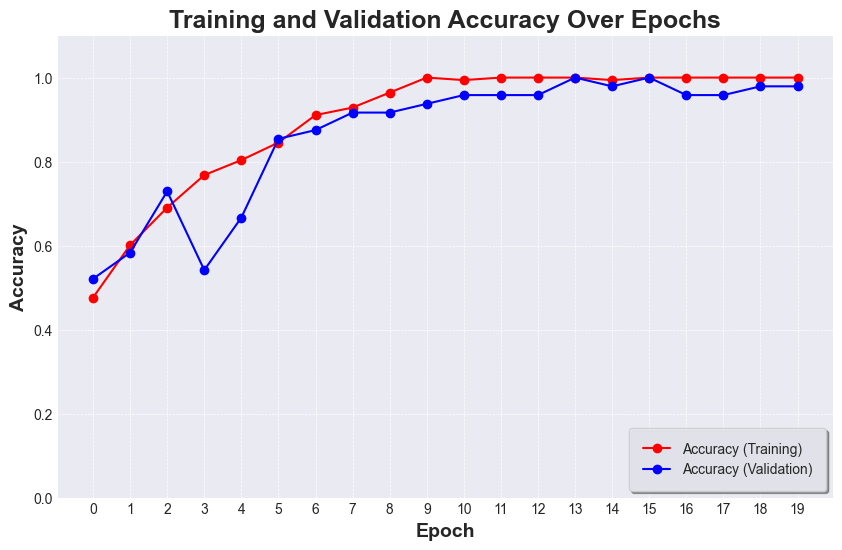

In [24]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(history.history['accuracy'], color='red', marker='o', label='Accuracy (Training)')
ax.plot(history.history['val_accuracy'], color='blue', marker='o', label='Accuracy (Validation)')

ax.set_title('Training and Validation Accuracy Over Epochs', fontsize=18, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')

ax.set_ylim([0, 1.1])

ax.set_xticks(np.arange(start=0, stop=len(history.history['loss']), step=1))

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

legend = ax.legend(frameon=True, framealpha=0.9, shadow=True, borderpad=1, loc='lower right')

plt.show()

In [39]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y,yhat)
    recall.update_state(y,yhat)
    accuracy.update_state(y,yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [41]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


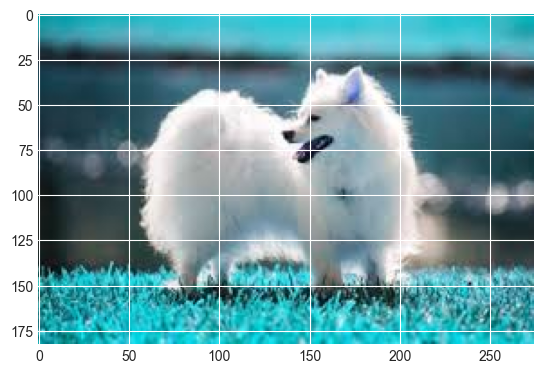

In [27]:
# Viewing test image (outside of subsets)
img = cv2.imread('test.jpg')
plt.imshow(img)
plt.show()

In [29]:
resized = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resized/255, 0))
if yhat < 0.5:
    print('Predicted class is a dog')
else:
    print("Predicted class is a horse")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class is a dog


In [46]:
# Saving the model
model.save(os.path.join('models', 'dogsvshorses_V2.0.h5'))

In [54]:
# Testing model on the test batch
false_positives = 0
true_positives = 0
false_negatives = 0
true_negatives = 0
for test_case in test.as_numpy_iterator():
    X = test_case[0]
    y = test_case[1]
    y_hat = model.predict(X)
    y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

    for i in range(len(y_hat)):
        if y[i] == 0:
            if y_hat[i] == 0: true_negatives+=1
            else: false_positives+=1
        if y[i] == 1:
            if y_hat[i] == 0: false_negatives+=1
            else: true_positives+=1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [55]:
print(f"False positives: {false_positives}")
print(f"True positives: {true_positives}")
print(f"False negatives: {false_negatives}")
print(f"True negatives: {true_negatives}")

False positives: 0
True positives: 16
False negatives: 0
True negatives: 8
